In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from incense import ExperimentLoader
import seaborn as sns

import os
import dotenv

dotenv.load_dotenv()

MONGO_URI = os.getenv('LOCAL_MONGO_URI')
MONGO_DB_NAME = os.getenv('LOCAL_MONGO_DB_NAME')
MONGO_EXP_NAME = os.getenv('LOCAL_MONGO_EXP_NAME')

DEFAULT_FILTER_TAGS = ['BAD', 'DUPE']
DB_QUERY = {"$and": [
    {'experiment.name': MONGO_EXP_NAME},
    {'status': 'COMPLETED'},
    {'omniboard.tags': {'$nin': DEFAULT_FILTER_TAGS}},
    {'config.nu': {'$eq': 0.1}},
    {'config.single_sim': {'$eq': True}}
]}


def last(x): return x.iloc[-1]


loader = ExperimentLoader(
    mongo_uri=MONGO_URI,
    db_name=MONGO_DB_NAME
)

exps = loader.find(DB_QUERY)

In [6]:
metrics = ('E1', 'E2', 'G12', 'nu12', 'nu21', 'eta121', 'eta122',
           'Normed_Eigenvalue_0', 'Normed_Eigenvalue_1')
metric_dicts = [{f'metrics.{m}': last} for m in metrics]
configs = ('basis_v', 'extremal_mode', 'init_run_idx')
config_list = [f'config.{c}' for c in configs]

df = exps.project(on=[*metric_dicts,
                      *config_list
                      ])

df.rename(columns={c: c.removesuffix("_last") for c in df.columns},
          inplace=True)
df['init_run_idx_dupe'] = df['init_run_idx'].duplicated()

# df.head(20)
print(len(df))
# df.drop_duplicates(subset=['init_run_idx'],
#    inplace=True)
# print(len(df))
# df.head(10)

142


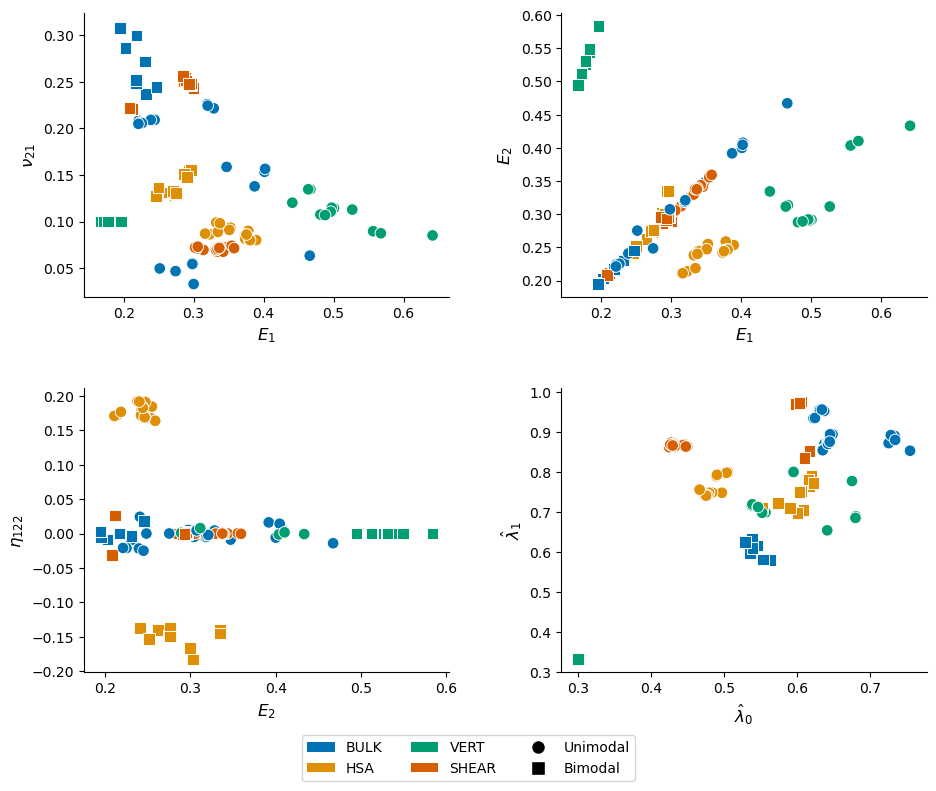

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
# the same kwargs used for all plots
kwargs = dict(data=df,
              hue='basis_v',
              style='extremal_mode',
              markers={1: 'o', 2: 's'},
              s=70,
              legend=False,
              palette='colorblind',
              )
# pairs of x and y keys into the dataframe
xys = (
    ('E1', 'nu21'),
    ('E1', 'E2'),
    ('E2', 'eta122'),
    ('Normed_Eigenvalue_0', 'Normed_Eigenvalue_1')
)
# actual text we want as axes labels
labs = (
    (r'$E_1$', r'$\nu_{21}$'),
    (r'$E_1$', r'$E_2$'),
    (r'$E_2$', r'$\eta_{122}$'),
    (r'$\hat{\lambda}_0$', r'$\hat{\lambda}_1$')
)

for ax, xy, lab in zip(axs.flatten(), xys, labs):
    sns.scatterplot(x=xy[0],
                    y=xy[1],
                    ax=ax,
                    **kwargs)
    ax.set_xlabel(lab[0], fontsize=12)
    ax.set_ylabel(lab[1], fontsize=12)
    [ax.spines[s].set_visible(False) for s in ('top', 'right')]
    plt.tight_layout(pad=3.0)

color_legend = [Patch(facecolor=c, label=l)
                for l, c in
                zip(df['basis_v'].unique(),
                    sns.color_palette(kwargs['palette'])[:5])]
marker_legend = [Line2D([0], [0],
                        marker=m,
                        color='w',
                        markerfacecolor='k',
                        markersize=10,
                        linestyle='None',
                        label=l)
                 for m, l in
                 zip(kwargs['markers'].values(),
                     ['Unimodal', 'Bimodal'])]
fig.legend(handles=color_legend + marker_legend,
           loc='upper center',
           ncol=3,
           bbox_to_anchor=(0.5, 0.05),
           fontsize=10)